In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import re
import json
import random
import time
import pickle
from brokenaxes import brokenaxes
from striprtf.striprtf import rtf_to_text
from glob import glob
from multiprocessing import Pool
from scipy.io import mmread
from collections import OrderedDict
import pandas as pd
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, zscore, ttest_ind, ranksums, spearmanr, fisher_exact
import os, sys
import statsmodels.api as sm
from copy import deepcopy
import numpy as np
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict
from scipy.stats import linregress

from statannotations.Annotator import Annotator
import matplotlib.cm as cm

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
from scipy import stats
from tqdm import tqdm
import glob

from scipy.stats import zscore
import pysam as ps
from matplotlib import gridspec,cm
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def p2signif(p):
    if p<.05:
        if p<.01:
            if p<.001: return "***"
            else: return "**"
        else: return "*"
    else: return ""

In [3]:
data={}
sample=[x.split('.')[0].split('_')[1] for x in os.listdir('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/figure2') if x[:6]=="refine"]
for i in sample:
    try:
        data[i]=pd.read_table('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/figure2/refine_'+i+'.txt',index_col=0,sep=',')
        data[i].insert(3,'intersize',data[i]["end"]-data[i]["start"])
    except:
        continue

In [4]:
## read the reads information of each sample
total_reads = pd.read_table('/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/total_reads.txt',header=None,index_col=0)
total_reads.index = [x.split(".")[0].split("_")[0] + x.split(".")[0].split("_")[1]for x in total_reads.index]

In [5]:
## subtract selected sample
sample_reads = total_reads.loc[sample,:]
sample_data=sample_reads.copy()

In [6]:
## calculate epm, insert size, selected size ecpm
sample_data.columns=["total_reads"]
sample_data["ecc_number"]=sample_data.apply(lambda x:data[x.name][data[x.name]["count"]>=1].shape[0],axis=1)
sample_data["epm"]=sample_data["ecc_number"]/sample_data["total_reads"] * 1000000
sample_data["intersize"]=sample_data.apply(lambda x:abs(data[x.name]["end"]-data[x.name]["start"]).values,axis=1)
sample_data["ec_count"]=sample_data.apply(lambda x:len([y for y in x["intersize"] if (y >= 1000) & (y <= 1000000)]),axis=1)
sample_data["ecpm"]=sample_data["ec_count"]/sample_data["total_reads"] * 1000000

sample_data["group"]=["Mouse"  if x[:5] == "mouse" else "Human" for x in sample_data.index]
sample_data["name"]=[x.split("HG")[1][:4] for x in sample_data.index]
sample_data["ratio"]=sample_data["ec_count"]/sample_data["ecc_number"]

In [7]:
sample_data.head()

,total_reads,ecc_number,epm,intersize,ec_count,ecpm,group,name,ratio
R22041543-T266-HG1471combined,68620005,237,3.453803,"[626, 1385, 378, 1101, 356, 1143, 811, 640, 22...",108,1.573885,Human,1471,0.455696
R22041543-T266-HG1470combined,61683816,178,2.885684,"[343996, 2004, 3364, 706, 1029, 3148, 4599, 37...",91,1.475265,Human,1470,0.511236
R22051616-T279-HG1534combined,40614854,87,2.142073,"[753, 1975, 151, 195, 200, 1452, 200, 18, 206,...",15,0.369323,Human,1534,0.172414
mouseR22041543-T266-HG1470,120645751,395,3.274048,"[366, 204, 177, 209, 184, 178, 176, 325, 188, ...",3,0.024866,Mouse,1470,0.007595
R22051616-T279-HG1535combined,37356842,251,6.718983,"[18, 169, 799783, 475, 911, 2108, 200, 1359, 2...",79,2.114740,Human,1535,0.314741


### Sfigure3 Correlation between tumor-derived and non-tumor-derived cell-free eccDNA density and coding gene density

In [8]:
def genome_length(genome):
    #Get the length of each chromosome
    fasta = ps.Fastafile(genome)
    output = pd.DataFrame([fasta.lengths], columns=fasta.references, index=['length']).T
    output = output.drop(list(output.filter(regex='_',axis=0).index))
    return output

In [9]:
hg19_reference = '/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/Sfigure3_reference/fasta/hg19/hg19.fa'
hg19_length = genome_length(hg19_reference)

mm10_reference = '/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/Sfigure3_reference/fasta/mm10/mm10.fa'
mm10_length = genome_length(mm10_reference)

In [10]:
hg19_gtf_table = pd.read_csv("/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/Sfigure3_reference/gtf/all_annotation/hg19.gencode.gtf", sep ='\t', header=None, skiprows=5)
hg19_test = hg19_gtf_table[hg19_gtf_table[2]=='gene']
hg19_test.insert(9,9,hg19_test[8].apply(lambda x: x.split(';')[2].split('"')[1]))

mm10_gtf_table = pd.read_csv("/home/luosongwen/scantecc/2025_03_10_Figure_result/Data/Sfigure3_reference/gtf/all_annotation/mm10.gencode.gtf", sep ='\t', header=None, skiprows=5)
mm10_test = mm10_gtf_table[mm10_gtf_table[2]=='gene']
mm10_test.insert(9,9,mm10_test[8].apply(lambda x: x.split(';')[1].split('"')[1]))

In [11]:
### 计算人类(human，癌种来源)和小鼠(mouse，非癌种来源)染色体上的蛋白编码基因密度
density_human_plot = pd.DataFrame(0, index = ['chr{0}'.format(a) for a in list(range(1,23))+['X','Y','M']], columns=['coding_gene','large','small'])
density_mouse_plot = pd.DataFrame(0, index = ['chr{0}'.format(a) for a in list(range(1,20))+['X','Y','M']], columns=['coding_gene','large','small'])
for i in density_human_plot.index:
    density_human_plot.loc[i,'coding_gene'] =((len(hg19_test[(hg19_test[9]=='protein_coding')&(hg19_test[0]==i)])/ hg19_length.loc[i,'length']))*1e6
for i in density_mouse_plot.index:
    density_mouse_plot.loc[i,'coding_gene'] =((len(mm10_test[(mm10_test[9]=='protein_coding')&(mm10_test[0]==i)])/ mm10_length.loc[i,'length']))*1e6

In [12]:
merge_human_small = pd.DataFrame(); merge_human_large = pd.DataFrame(); merge_human = pd.DataFrame();
merge_mouse_small = pd.DataFrame(); merge_mouse_large = pd.DataFrame(); merge_mouse = pd.DataFrame()
for i in sample:
    if (i[:5]!='mouse'):
        merge_human = pd.concat([merge_human,data[i]])
        merge_human_large = pd.concat([merge_human_large,data[i][data[i].intersize>1000]])
        merge_human_small = pd.concat([merge_human_small,data[i][data[i].intersize<=1000]])
    else:
        merge_mouse = pd.concat([merge_mouse,data[i]])
        merge_mouse_large = pd.concat([merge_mouse_large,data[i][data[i].intersize>1000]])
        merge_mouse_small = pd.concat([merge_mouse_small,data[i][data[i].intersize<=1000]])

In [13]:
merge_mouse.insert(0,'name',merge_mouse.index)
merge_human.insert(0,'name',merge_human.index)

In [14]:
#### 计算大、小片段 eccDNA 在染色体上的密度，并进行归一化
species_dict ={'human':'hg19','mouse':'mm10'}
for species in ['human','mouse']:
    temp_large = pd.DataFrame(locals()['merge_'+species+'_large']['chr'].value_counts())
    temp_small = pd.DataFrame(locals()['merge_'+species+'_small']['chr'].value_counts())
    for i in temp_large .index:
        locals()['density_'+species+'_plot'].loc[i, 'large'] += ((temp_large.loc[i,'count'])/ locals()[species_dict[species]+'_length'].loc[i,'length'])*1e6
        locals()['density_'+species+'_plot'].loc[i, 'small'] += ((temp_small.loc[i,'count'])/ locals()[species_dict[species]+'_length'].loc[i,'length'])*1e6

In [15]:
density_human_plot=density_human_plot.drop(['chrM'])
density_mouse_plot=density_mouse_plot.drop(['chrM'])

In [16]:
density_human_plot["total"] = density_human_plot["large"]+density_human_plot["small"]
density_mouse_plot["total"] = density_mouse_plot["large"]+density_mouse_plot["small"]

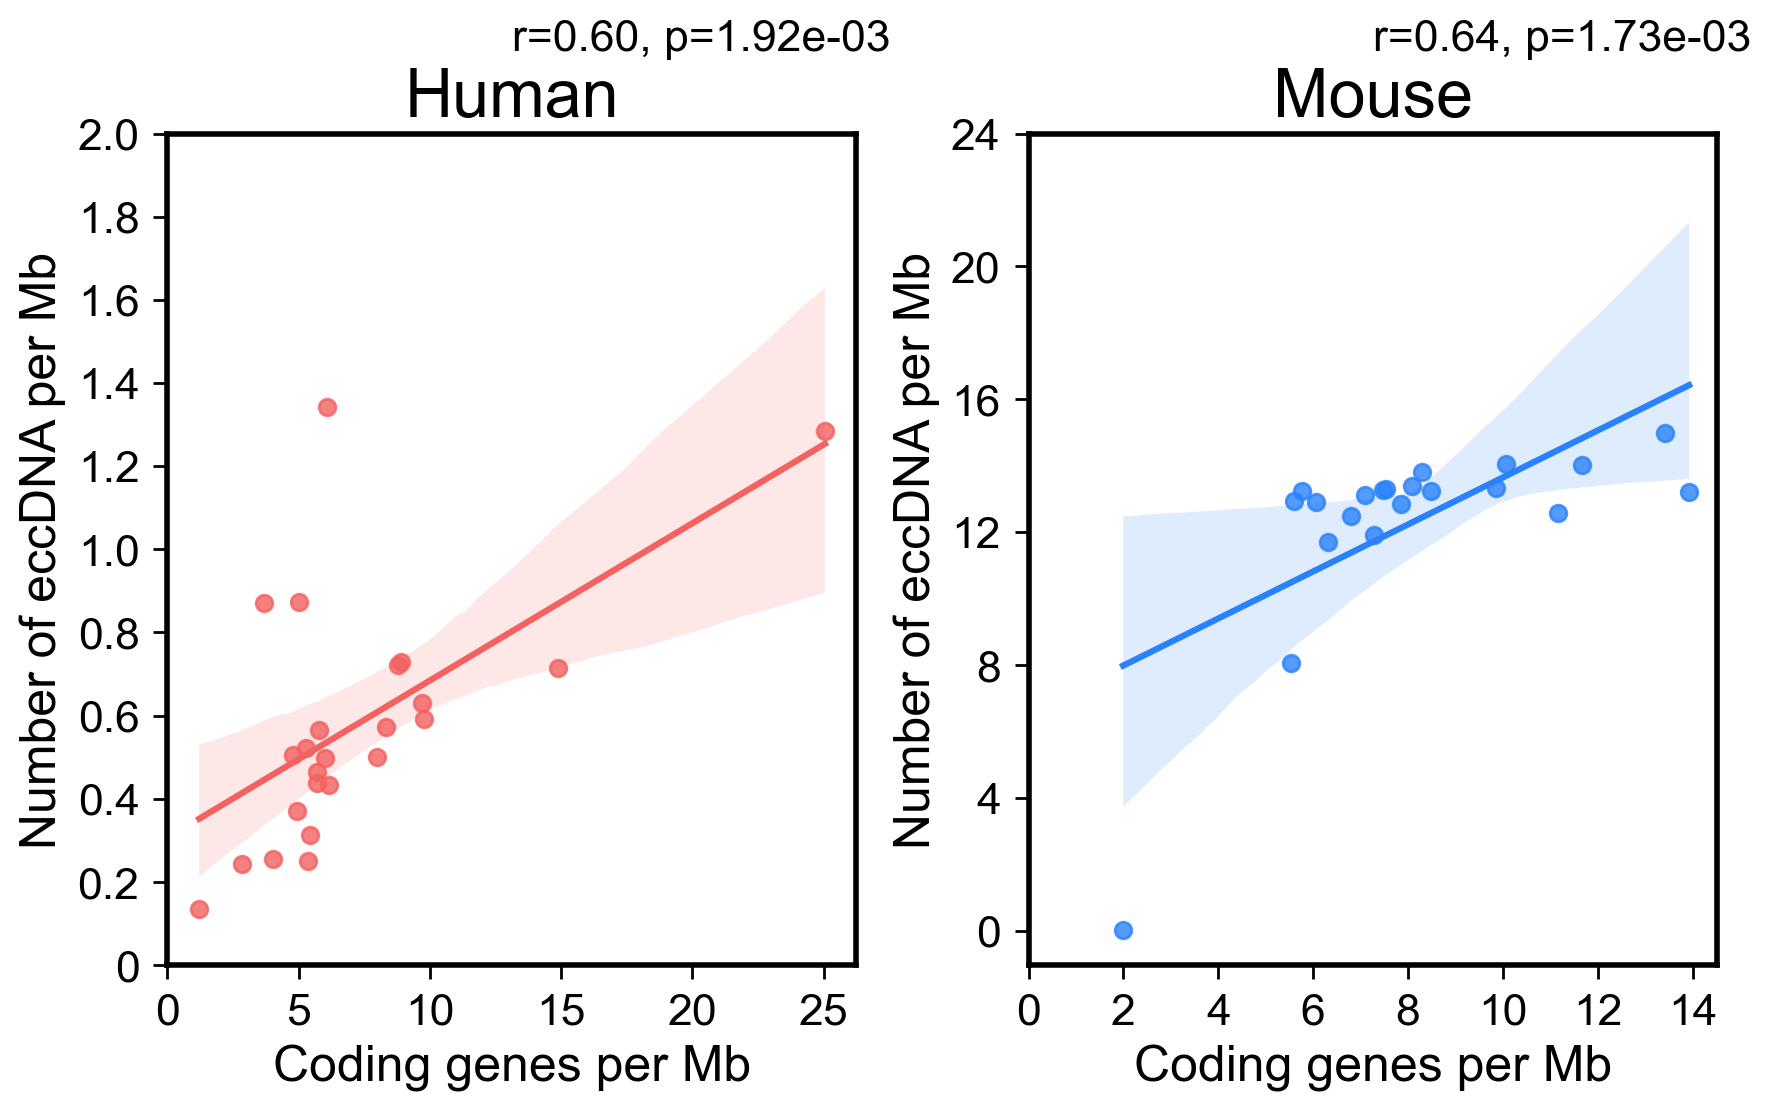

In [17]:
### Human/Mouse 每Mb 编码基因数目（编码基因密度）与每Mb eccDNA数目(eccDNA密度, total)
fig = plt.figure(figsize=(10, 5.4))
fig = gridspec.GridSpec(6, 8, hspace=0.1, wspace=4)

# 子图 1
ax1 = plt.subplot(fig[0:6, 0:4])
sns.regplot(data=density_human_plot, x='coding_gene', y='total', ax=ax1, color='#F36161')

# 计算 r 值和 p 值
slope, intercept, r_value, p_value, std_err = linregress(density_human_plot['coding_gene'], density_human_plot['total'])
ax1.text(0.5, 1.1, f'r={r_value:.2f}, p={p_value:.2e}', transform=ax1.transAxes, fontsize=16)

ax1.set_title('Human', fontsize=24)
ax1.set_xticks(range(0, 30, 5))
ax1.set_yticks([0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax1.set_xticklabels(range(0, 30, 5), fontsize=18)
ax1.set_yticklabels([0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], fontsize=18)

# 设置刻度标签大小
ax1.tick_params(axis='x', labelsize=16, pad=5, direction='out')
ax1.tick_params(axis='y', labelsize=16, pad=5, direction='out')

ax1.set_xlabel('Coding genes per Mb', fontsize=18)
ax1.set_ylabel('Number of eccDNA per Mb', fontsize=18)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.tick_params(axis='both', which='both', direction='out', length=5, width=1, colors='black', grid_color='black', grid_alpha=0.5)

# 子图 2
ax2 = plt.subplot(fig[0:6, 4:8])
sns.regplot(data=density_mouse_plot, x='coding_gene', y='total', ax=ax2, color='#2982FB')

# 计算 r 值和 p 值
slope, intercept, r_value, p_value, std_err = linregress(density_mouse_plot['coding_gene'], density_mouse_plot['total'])
ax2.text(0.5, 1.1, f'r={r_value:.2f}, p={p_value:.2e}', transform=ax2.transAxes, fontsize=16)

ax2.set_title('Mouse', fontsize=24)
ax2.set_xticks(range(0, 16, 2))
ax2.set_yticks([0, 4, 8, 12, 16, 20, 24])
ax2.set_xticklabels(range(0, 16, 2), fontsize=18)
ax2.set_yticklabels([0, 4, 8, 12, 16, 20, 24], fontsize=18)

# 设置刻度标签大小
ax2.tick_params(axis='x', labelsize=16, pad=5, direction='out')
ax2.tick_params(axis='y', labelsize=16, pad=5, direction='out')

ax2.set_xlabel('Coding genes per Mb', fontsize=18)
ax2.set_ylabel('Number of eccDNA per Mb', fontsize=18)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['top'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax2.tick_params(axis='both', which='both', direction='out', length=5, width=1, colors='black', grid_color='black', grid_alpha=0.5)
#plt.savefig('./Sfig3B_human_coding_gene.pdf',bbox_inches='tight')
plt.show()

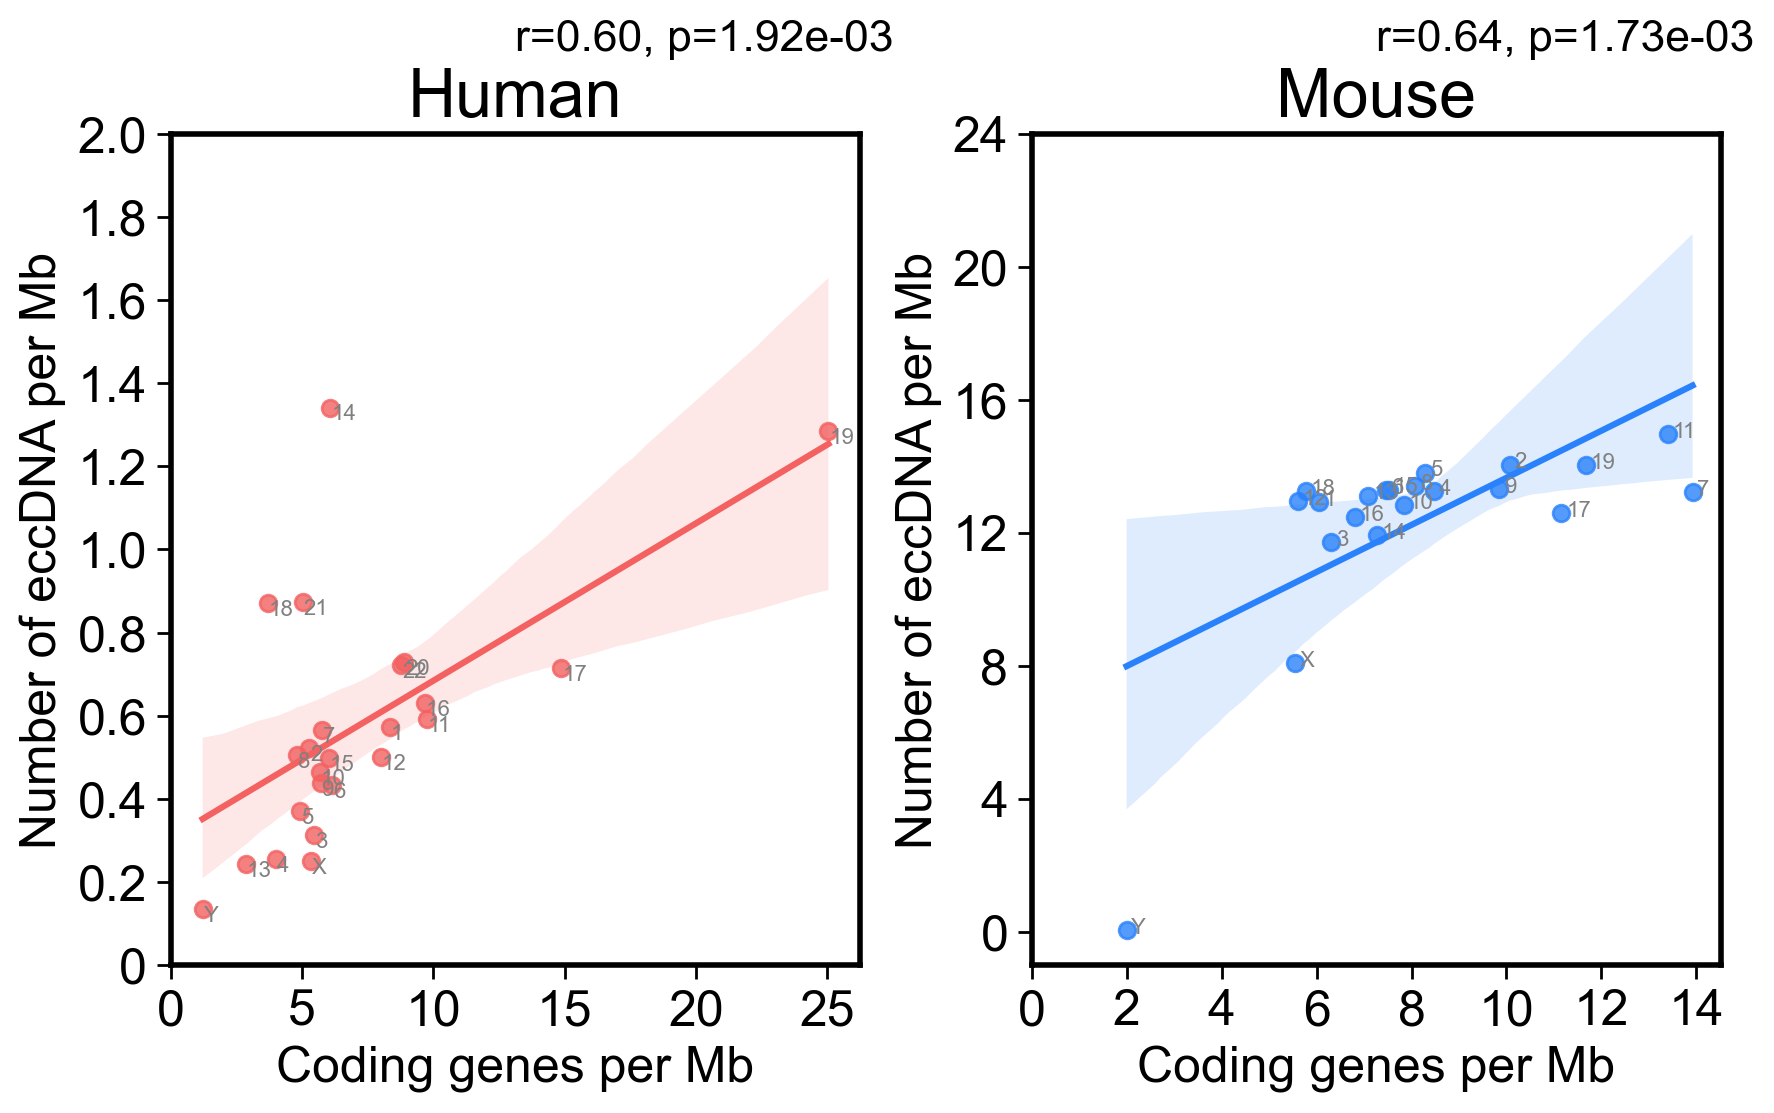

In [18]:
### Human/Mouse 每Mb 编码基因数目（编码基因密度）与每Mb eccDNA数目(eccDNA密度, total)
fig = plt.figure(figsize=(10, 5.4))
fig = gridspec.GridSpec(6, 8, hspace=0.1, wspace=4)

# 子图 1 - Human
ax1 = plt.subplot(fig[0:6, 0:4])
sns.regplot(data=density_human_plot, x='coding_gene', y='total', ax=ax1, color='#F36161')

# 在每个点上添加染色体编号（去掉 'chr'，标到点上方）
for i in range(density_human_plot.shape[0]):
    label = str(density_human_plot.index[i])
    label = label.replace('chr', '')  # 去掉 "chr"
    ax1.text(
        density_human_plot['coding_gene'].iloc[i]+0.03,  # X轴右偏一点
        density_human_plot['total'].iloc[i]-0.03,       # Y轴下偏一点
        label,
        fontsize=8,
        color='gray'
        #ha='left',  # 水平方向靠左对齐
        #va='bottom' # 垂直方向底部对齐
    )

# 计算 r 值和 p 值
slope, intercept, r_value, p_value, std_err = linregress(density_human_plot['coding_gene'], density_human_plot['total'])
ax1.text(0.5, 1.1, f'r={r_value:.2f}, p={p_value:.2e}', transform=ax1.transAxes, fontsize=16)

ax1.set_title('Human', fontsize=24)
ax1.set_xticks(range(0, 30, 5))
ax1.set_yticks([0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax1.set_xticklabels(range(0, 30, 5), fontsize=18)
ax1.set_yticklabels([0, .2, .4, .6, .8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], fontsize=18)
ax1.set_xlabel('Coding genes per Mb', fontsize=18)
ax1.set_ylabel('Number of eccDNA per Mb', fontsize=18)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.tick_params(axis='both', which='both', direction='out', length=5, width=1, colors='black', grid_color='black', grid_alpha=0.5)

# 子图 2 - Mouse
ax2 = plt.subplot(fig[0:6, 4:8])
sns.regplot(data=density_mouse_plot, x='coding_gene', y='total', ax=ax2, color='#2982FB')

# 在每个点上添加染色体编号（去掉 'chr'，标到点上方）
for i in range(density_mouse_plot.shape[0]):
    label = str(density_mouse_plot.index[i])
    label = label.replace('chr', '')  # 去掉 "chr"
    ax2.text(
        density_mouse_plot['coding_gene'].iloc[i]+0.1,
        density_mouse_plot['total'].iloc[i]-0.1,
        label,
        fontsize=8,
        color='gray'
        #ha='left',
        #va='bottom'
    )

# 计算 r 值和 p 值
slope, intercept, r_value, p_value, std_err = linregress(density_mouse_plot['coding_gene'], density_mouse_plot['total'])
ax2.text(0.5, 1.1, f'r={r_value:.2f}, p={p_value:.2e}', transform=ax2.transAxes, fontsize=16)

ax2.set_title('Mouse', fontsize=24)
ax2.set_xticks(range(0, 16, 2))
ax2.set_yticks([0, 4, 8, 12, 16, 20, 24])
ax2.set_xticklabels(range(0, 16, 2), fontsize=18)
ax2.set_yticklabels([0, 4, 8, 12, 16, 20, 24], fontsize=18)

#ax2.set_ylim(bottom=0)

ax2.set_xlabel('Coding genes per Mb', fontsize=18)
ax2.set_ylabel('Number of eccDNA per Mb', fontsize=18)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['top'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax2.tick_params(axis='both', which='both', direction='out', length=5, width=1, colors='black', grid_color='black', grid_alpha=0.5)

# 保存或展示
#plt.savefig('/home/luosongwen/scantecc/2025_03_10_Figure_result/candidate_figure/sFigure3_NC_refined.pdf', bbox_inches='tight')
plt.show()